In [1]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def count_files_in_directory(directory):
    """ Counts files in each subdirectory of a given directory. """
    counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):  # Ensure it's a directory
            count = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            counts[class_dir] = count
    return counts

dataset_directory = 'furniture-data' 
class_counts = count_files_in_directory(dataset_directory)

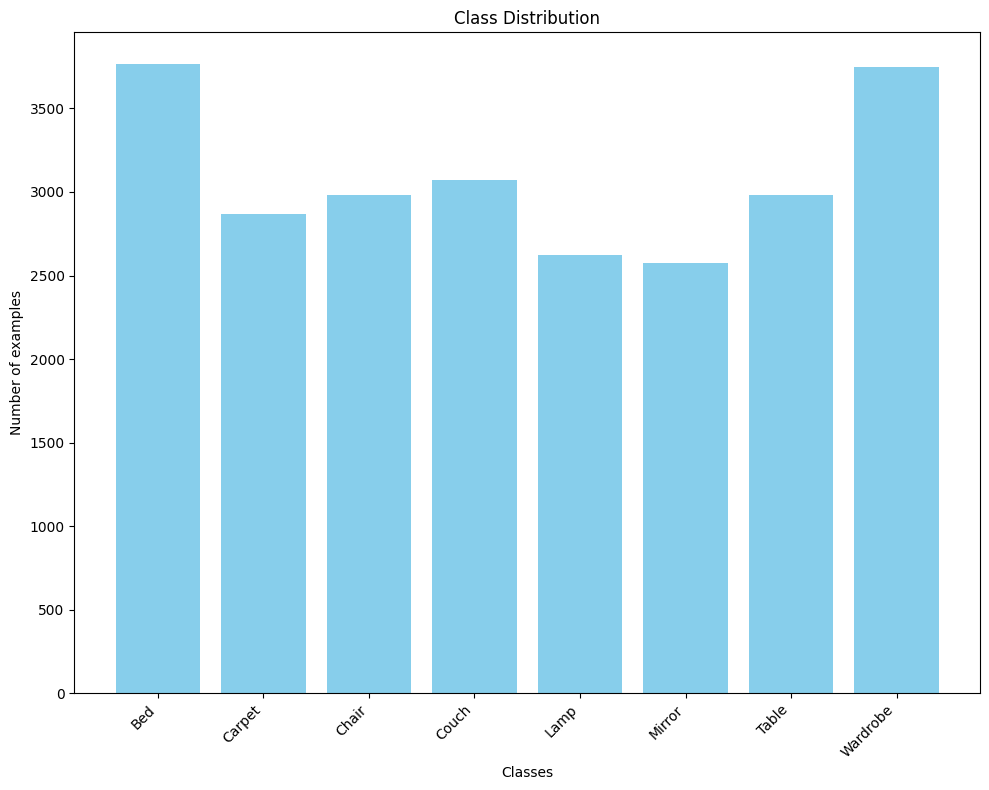

In [3]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_counts):
    """ Plots a bar chart of the class distribution given a dictionary of class counts. """
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 8))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of examples')
    plt.title('Class Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_class_distribution(class_counts)

In [4]:
widths = []
heights = []
for class_name in os.listdir("furniture-data"):
    class_dir = os.path.join("furniture-data", class_name)
    for filename in os.listdir(class_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, filename)
            with Image.open(img_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)

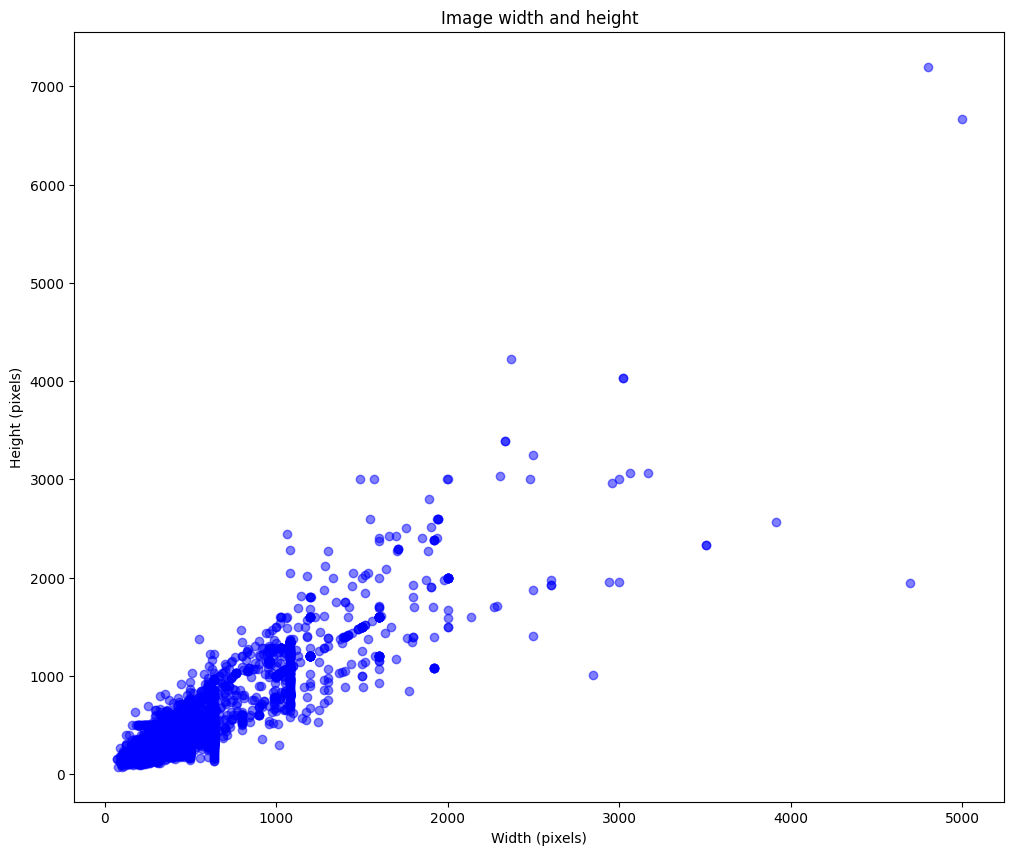

In [5]:
plt.figure(figsize=(12, 10))
plt.scatter(widths, heights, alpha=0.5, color='blue')

plt.title('Image width and height')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

# Show the scatter plot
plt.show()

In [6]:
img_size = (128, 128)
def preprocessing(image_, label):
    img = tf.image.resize(image_, img_size)
    img = (tf.cast(img, tf.float32) / 255.0)
    label = tf.one_hot(label, depth=8)
    return img, label

In [7]:
dataset_dir = "furniture-data"
batch_size = 16

dataset = image_dataset_from_directory(
    dataset_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42 
)

# Get class names
class_names = dataset.class_names

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomWidth(0.1),
    tf.keras.layers.RandomHeight(0.1),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomBrightness(0.4),
])

# Data augmentation
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.75 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

augmented_size = int(0.5 * tf.data.experimental.cardinality(train_dataset).numpy())

train_to_augment = train_dataset.take(augmented_size)
remaining_augment = train_dataset.skip(augmented_size)

augmented_train = train_to_augment.map(
    lambda image, label: (data_augmentation(image), label),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

combined_train_set = remaining_augment.concatenate(augmented_train)


# Apply preprocessing
combined_train_set = combined_train_set.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
validation_set = val_dataset.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
combined_train_set = combined_train_set.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Classes:", class_names)

Found 24620 files belonging to 8 classes.
Classes: ['Bed', 'Carpet', 'Chair', 'Couch', 'Lamp', 'Mirror', 'Table', 'Wardrobe']


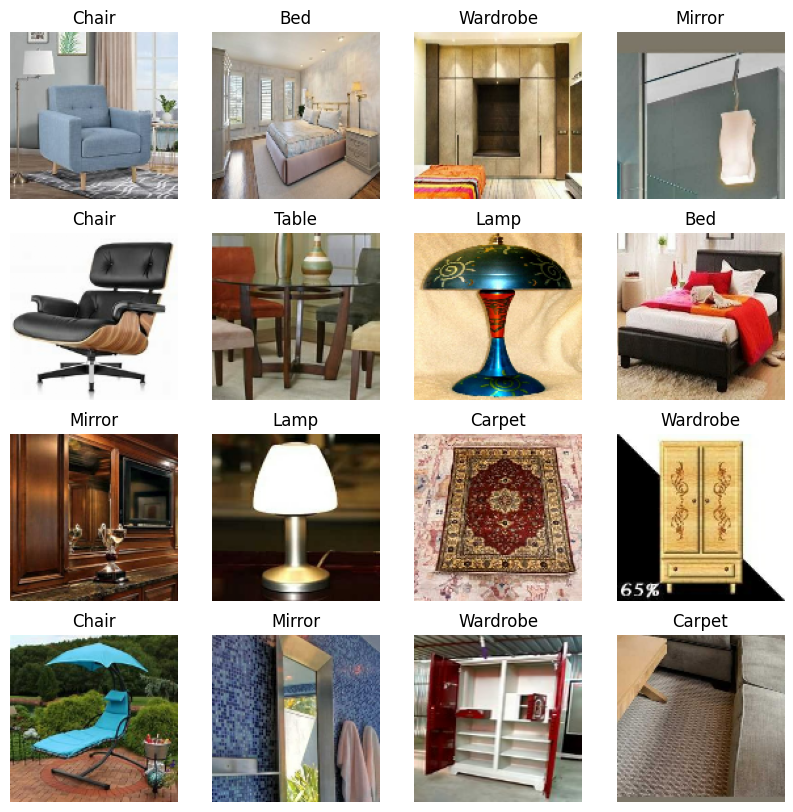

In [8]:
"Visualize a batch of images"
import numpy as np
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(len(image_batch)):
        ax = plt.subplot(4, 4, n + 1)
        img = image_batch[n].numpy()
        if img.max() > 1:  
            img = img / 255.0
        plt.imshow(img)
        plt.title(class_names[np.argmax(label_batch[n])])
        plt.axis("off")
    plt.show()

image_batch, label_batch = next(iter(combined_train_set))
show_batch(image_batch, label_batch)

In [9]:
#checking pixel values
for image_batch, label_batch in combined_train_set.take(1):
    print("Sample image pixel values:\n", image_batch[0].numpy())

Sample image pixel values:
 [[[0.2623315  0.25056678 0.2231158 ]
  [0.26086092 0.2490962  0.22164522]
  [0.25189808 0.24013337 0.21268238]
  ...
  [0.7269998  0.71131355 0.7152351 ]
  [0.7178668  0.7021805  0.7061021 ]
  [0.7229916  0.7073053  0.7112269 ]]

 [[0.26804534 0.25628063 0.22882965]
  [0.26731005 0.25554535 0.22809437]
  [0.27061456 0.25884986 0.23139888]
  ...
  [0.73962927 0.723943   0.72786456]
  [0.7234528  0.70776653 0.7116881 ]
  [0.7098499  0.6941636  0.6980852 ]]

 [[0.27489278 0.26312807 0.23567708]
  [0.27342218 0.26165748 0.2342065 ]
  [0.2674898  0.2557251  0.22827412]
  ...
  [0.7432639  0.7275776  0.7314992 ]
  [0.73333764 0.71765137 0.72157294]
  [0.7585562  0.7428699  0.7467915 ]]

 ...

 [[0.10017545 0.09625388 0.11586172]
  [0.08628983 0.08236826 0.1019761 ]
  [0.09227941 0.08835784 0.10796569]
  ...
  [0.1656791  0.16175753 0.18136537]
  [0.14265567 0.1387341  0.15834194]
  [0.1529328  0.14901122 0.16861907]]

 [[0.0848652  0.08094363 0.10055147]
  [0.0981

In [10]:
# Checking if there are any corrupt images
try:
    for image_batch, label_batch in combined_train_set:
        pass
except Exception as e:
    print("Error encountered:", e)

In [11]:
for images, labels in combined_train_set.take(1):
    print("Shape of labels:", labels.shape)

Shape of labels: (16, 8)


In [12]:
base_model = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

base_model.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True
for layer in base_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001, weight_decay=0.01),loss='categorical_crossentropy',metrics=['accuracy', 'precision', 'recall'])

In [13]:
frozen, trainable = 0, 0
for layer in model.layers:
    if layer.trainable:
        trainable += 1
    else:
        frozen += 1
    print(f'Layer {layer.name} is {"trainable" if layer.trainable else "frozen"}')
print(frozen, trainable)

Layer input_layer_1 is frozen
Layer rescaling is frozen
Layer normalization is frozen
Layer rescaling_1 is frozen
Layer stem_conv_pad is frozen
Layer stem_conv is frozen
Layer stem_bn is trainable
Layer stem_activation is frozen
Layer block1a_dwconv is frozen
Layer block1a_bn is trainable
Layer block1a_activation is frozen
Layer block1a_se_squeeze is frozen
Layer block1a_se_reshape is frozen
Layer block1a_se_reduce is frozen
Layer block1a_se_expand is frozen
Layer block1a_se_excite is frozen
Layer block1a_project_conv is frozen
Layer block1a_project_bn is trainable
Layer block1b_dwconv is frozen
Layer block1b_bn is trainable
Layer block1b_activation is frozen
Layer block1b_se_squeeze is frozen
Layer block1b_se_reshape is frozen
Layer block1b_se_reduce is frozen
Layer block1b_se_expand is frozen
Layer block1b_se_excite is frozen
Layer block1b_project_conv is frozen
Layer block1b_project_bn is trainable
Layer block1b_drop is frozen
Layer block1b_add is frozen
Layer block2a_expand_conv is

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 7,900,303 (30.14 MB)

 Trainable params: 6,560,612 (25.03 MB)

 Non-trainable params: 1,339,691 (5.11 MB)

In [15]:
"Training the model head and the batch norm layers"
epochs = 10
history1 = model.fit(combined_train_set, validation_data=validation_set, epochs=epochs)

Epoch 1/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 463s 376ms/step - accuracy: 0.6558 - loss: 1.0450 - precision: 0.7564 - recall: 0.5835 - val_accuracy: 0.9313 - val_loss: 0.2207 - val_precision: 0.9504 - val_recall: 0.9209
Epoch 2/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 436s 376ms/step - accuracy: 0.9025 - loss: 0.3066 - precision: 0.9195 - recall: 0.8899 - val_accuracy: 0.9444 - val_loss: 0.1887 - val_precision: 0.9561 - val_recall: 0.9345
Epoch 3/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 436s 376ms/step - accuracy: 0.9301 - loss: 0.2183 - precision: 0.9423 - recall: 0.9189 - val_accuracy: 0.9542 - val_loss: 0.1472 - val_precision: 0.9619 - val_recall: 0.9479
Epoch 4/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 432s 373ms/step - accuracy: 0.9469 - loss: 0.1697 - precision: 0.9544 - recall: 0.9393 - val_accuracy: 0.9524 - val_loss: 0.1575 - val_precision: 0.9603 - val_recall: 0.9464
Epoch 5/10
1154/1154 ━━━━━━━━━━━━━━━━━━━━ 425s 367ms/step - accuracy: 0.9555 - loss: 0.1344 - precision: 0.9632 - recall: 0.9498 - val_a

C:\Users\hecr\AppData\Local\Temp\ipykernel_8524\1854781397.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss': 'Train Loss', 'val_loss': 'Validation Loss'}, inplace=True)
C:\Users\hecr\AppData\Local\Temp\ipykernel_8524\1854781397.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy': 'Train Accuracy', 'val_accuracy': 'Validation Accuracy'}, inplace=True)
C:\Users\hecr\AppData\Local\Temp\ipykernel_8524\1854781397.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

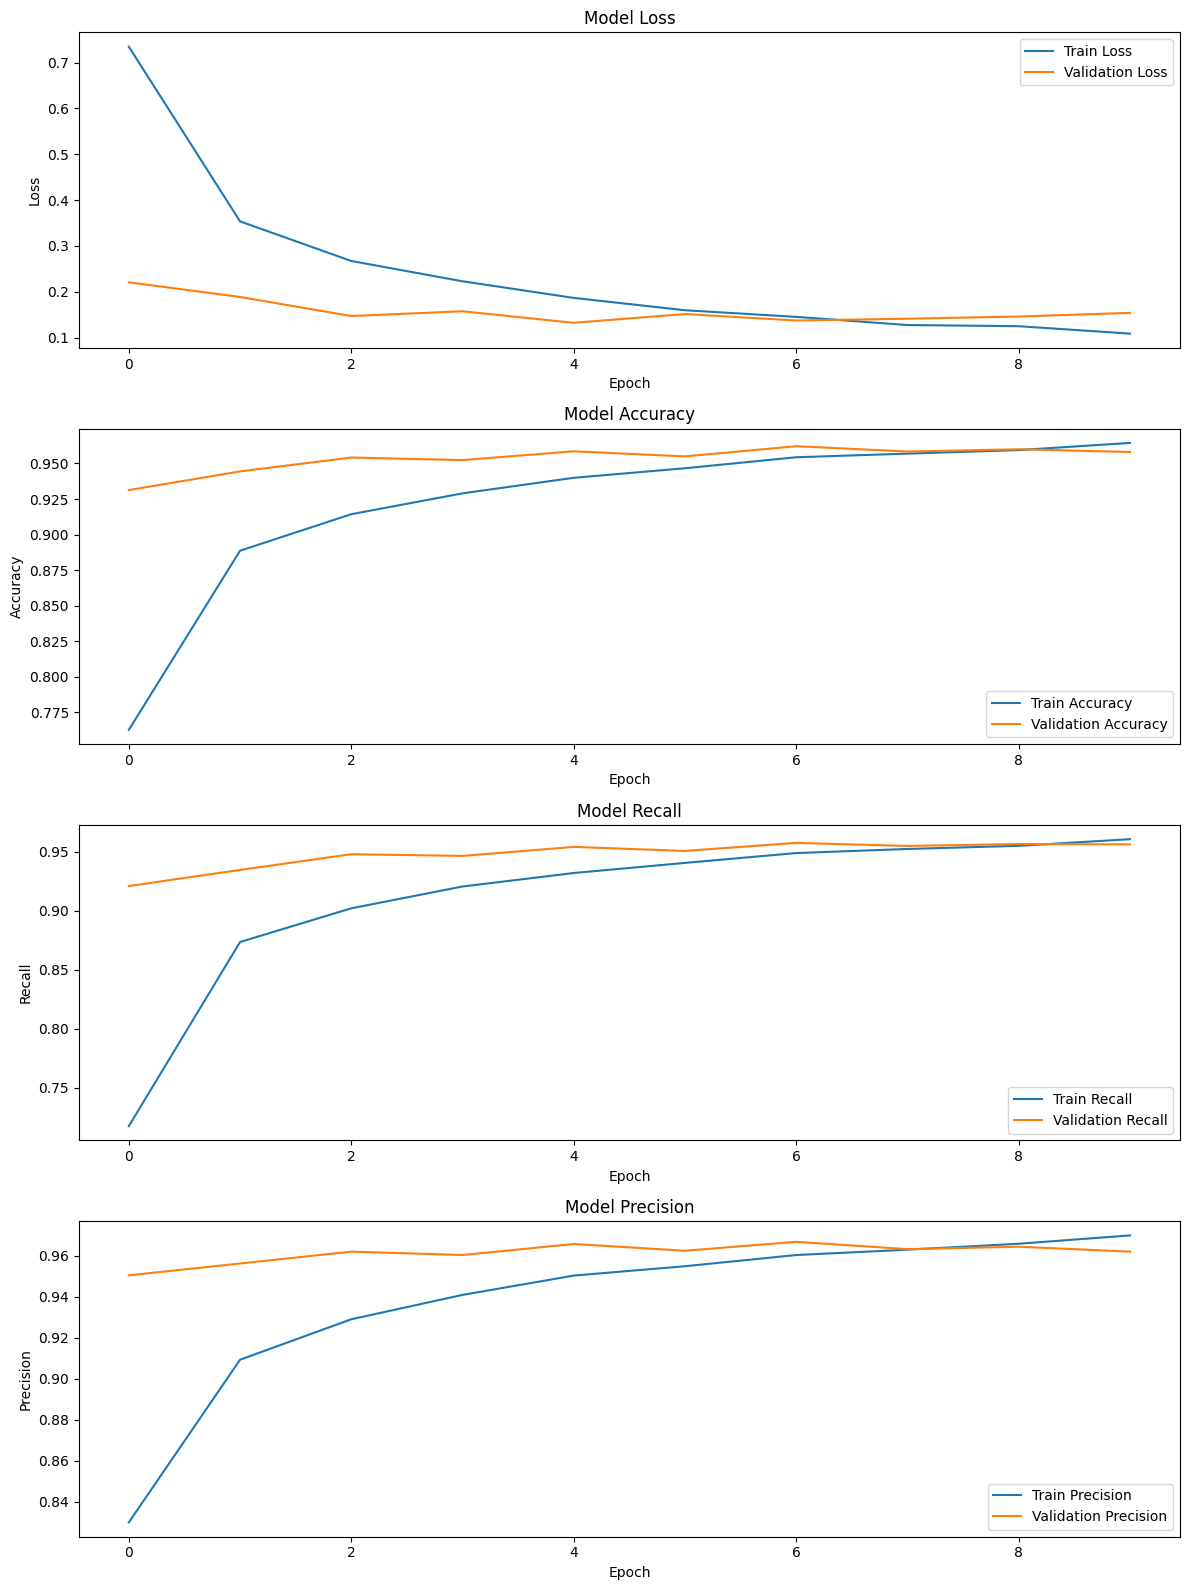

In [16]:
import pandas as pd

df_loss_acc = pd.DataFrame(history1.history)

# Extract loss and accuracy data
df_loss = df_loss_acc[['loss', 'val_loss']]
df_loss.rename(columns={'loss': 'Train Loss', 'val_loss': 'Validation Loss'}, inplace=True)

df_acc = df_loss_acc[['accuracy', 'val_accuracy']]
df_acc.rename(columns={'accuracy': 'Train Accuracy', 'val_accuracy': 'Validation Accuracy'}, inplace=True)

# Extract recall and precision data
df_recall = df_loss_acc[['recall', 'val_recall']]
df_recall.rename(columns={'recall': 'Train Recall', 'val_recall': 'Validation Recall'}, inplace=True)

df_precision = df_loss_acc[['precision', 'val_precision']]
df_precision.rename(columns={'precision': 'Train Precision', 'val_precision': 'Validation Precision'}, inplace=True)

# Plotting each metric in separate subplots
plt.figure(figsize=(12, 16))

# Plot loss
plt.subplot(4, 1, 1)
df_loss.plot(ax=plt.gca(), title='Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot accuracy
plt.subplot(4, 1, 2)
df_acc.plot(ax=plt.gca(), title='Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Plot recall
plt.subplot(4, 1, 3)
df_recall.plot(ax=plt.gca(), title='Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')

# Plot precision
plt.subplot(4, 1, 4)
df_precision.plot(ax=plt.gca(), title='Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [25]:
import numpy as np
def preprocess_for_prediction(image, img_size=(128, 128)):
    """Preprocess images for inference"""
    img = tf.image.resize(image, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)
    
    return img

def load_and_preprocess_image(image_path):
    """Load image for inference"""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = preprocess_for_prediction(img, img_size)
    
    return img

image_path = 'test_images/bed.jpg'
preprocessed_image = load_and_preprocess_image(image_path)
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)
print(f"Predicted class: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted class: Bed


In [27]:
model.save("furniture-modelv6.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


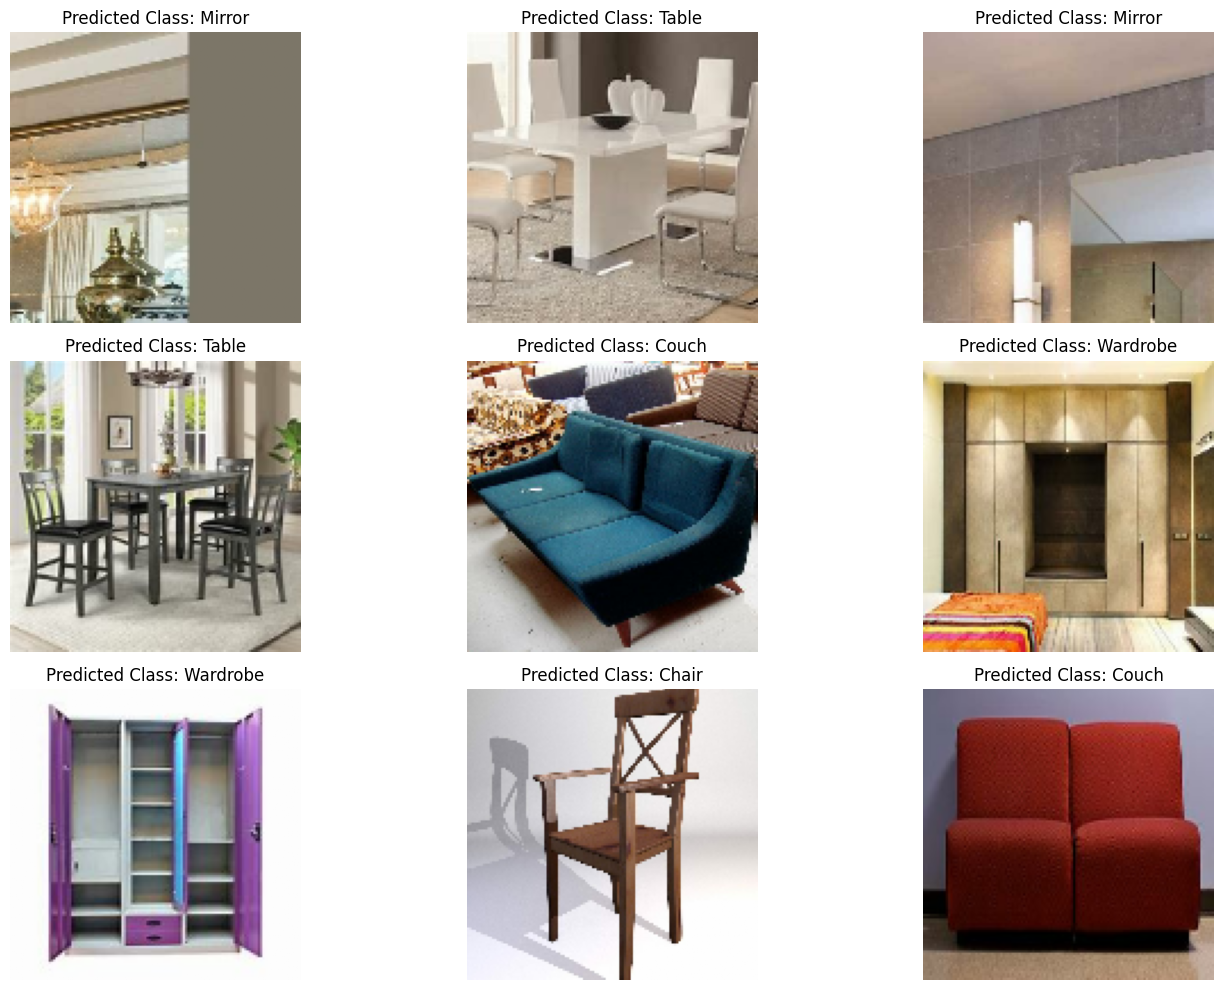

: 

In [31]:
import random
def infer_and_visualize(folder_path):
    """Process random images in a folder, infer them using the model, and visualize results."""
    images = os.listdir(folder_path)
    random.shuffle(images)
    plt.figure(figsize=(15, 10))

    for i, image_name in enumerate(images[:9]):
        image_path = os.path.join(folder_path, image_name)
        img = load_and_preprocess_image(image_path)
        
        predictions = model.predict(img)
        predicted_class = tf.argmax(predictions, axis=1).numpy()[0] 

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(img).numpy())
        plt.title(f'Predicted Class: {class_names[predicted_class]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

test_images_folder = 'test_images'
infer_and_visualize(test_images_folder)